## Load Data

In [1]:
import glob
import torch
import numpy as np
import warnings
warnings.simplefilter("ignore")

/private/home/theop123/miniconda3/envs/habitat-challenge/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
obs_paths = glob.glob("demo_data/obs_*.npy")
pose_delta_paths = glob.glob("demo_data/pose_delta_*.npy")
device = torch.device("cuda:0")

obs = torch.stack([
    torch.from_numpy(np.load(obs_path)) 
    for obs_path in obs_paths
]).unsqueeze(0).to(device)

pose_delta = torch.stack([
    torch.from_numpy(np.load(pose_delta_path)) 
    for pose_delta_path in pose_delta_paths
]).unsqueeze(0).to(device)

In [3]:
# frame containing (RGB, depth, segmentation) of shape 
# (batch_size, sequence_length, 3 + 1 + num_sem_categories, frame_height, frame_width)
obs.shape

torch.Size([1, 70, 20, 480, 640])

In [4]:
# sensor pose delta (dy, dx, dtheta) since last frame of shape 
# (batch_size, sequence_length, 3)
pose_delta.shape

torch.Size([1, 70, 3])

## Map Initialization

In [5]:
from home_robot.agent.mapping.dense.semantic.categorical_2d_semantic_map_state import Categorical2DSemanticMapState
from home_robot.agent.mapping.dense.semantic.categorical_2d_semantic_map_module import Categorical2DSemanticMapModule

# State holds global and local map and sensor pose
# See class definition for argument info
semantic_map = Categorical2DSemanticMapState(
    device=device,
    num_environments=1,
    num_sem_categories=16,
    map_resolution=5,
    map_size_cm=4800,
    global_downscaling=2,
)
semantic_map.init_map_and_pose()

# Module is responsible for updating the local and global maps and poses
# See class definition for argument info
semantic_map_module = Categorical2DSemanticMapModule(
    frame_height=480,
    frame_width=640,
    camera_height=0.88,
    hfov=79.0,
    num_sem_categories=16,
    map_size_cm=4800,
    map_resolution=5,
    vision_range=100,
    global_downscaling=2,
    du_scale=4,
    cat_pred_threshold=5.0,
    exp_pred_threshold=1.0,
    map_pred_threshold=1.0,
).to(device)

## Map Update

In [6]:
sequence_length = obs.shape[1]
num_sem_categories = obs.shape[2] - 4
dones = torch.tensor([False] * sequence_length).unsqueeze(0).to(device)
update_global = torch.tensor([True] * sequence_length).unsqueeze(0).to(device)

(
    seq_map_features,
    semantic_map.local_map,
    semantic_map.global_map,
    seq_local_pose,
    seq_global_pose,
    seq_lmb,
    seq_origins,
) = semantic_map_module(
    obs,
    pose_delta,
    dones,
    update_global,
    semantic_map.local_map,
    semantic_map.global_map,
    semantic_map.local_pose,
    semantic_map.global_pose,
    semantic_map.lmb,
    semantic_map.origins,
)
    
semantic_map.local_pose = seq_local_pose[:, -1]
semantic_map.global_pose = seq_global_pose[:, -1]
semantic_map.lmb = seq_lmb[:, -1]
semantic_map.origins = seq_origins[:, -1]

In [7]:
# Global semantic map of shape 
# (batch_size, num_channels, M, M)
#
# where num_channels = 4 + num_sem_categories
# 0: obstacle map
# 1: explored area
# 2: current agent location
# 3: past agent locations
# 4, 5, 6, .., num_sem_categories + 3: semantic categories
semantic_map.global_map.shape

torch.Size([1, 20, 960, 960])

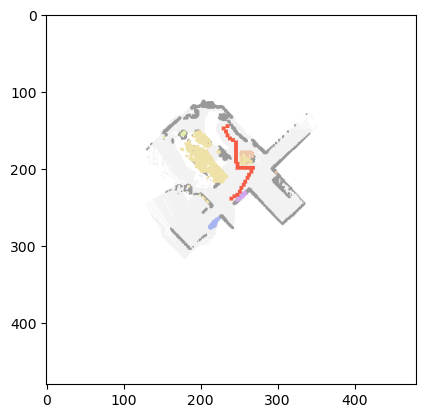

In [8]:
# Local semantic map visualization

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from home_robot.agent.perception.detection.coco_maskrcnn.coco_categories import (
    coco_categories_color_palette,
)

map_color_palette = [
    1.0,
    1.0,
    1.0,  # empty space
    0.6,
    0.6,
    0.6,  # obstacles
    0.95,
    0.95,
    0.95,  # explored area
    0.96,
    0.36,
    0.26,  # visited area
    *coco_categories_color_palette,
]
map_color_palette = [int(x * 255.0) for x in map_color_palette]

semantic_categories_map = semantic_map.get_semantic_map(0)
obstacle_map = semantic_map.get_obstacle_map(0)
explored_map = semantic_map.get_explored_map(0)
visited_map = semantic_map.get_visited_map(0)

semantic_categories_map += 4
no_category_mask = semantic_categories_map == 4 + num_sem_categories - 1
obstacle_mask = np.rint(obstacle_map) == 1
explored_mask = np.rint(explored_map) == 1
visited_mask = visited_map == 1
semantic_categories_map[no_category_mask] = 0
semantic_categories_map[np.logical_and(no_category_mask, explored_mask)] = 2
semantic_categories_map[np.logical_and(no_category_mask, obstacle_mask)] = 1
semantic_categories_map[visited_mask] = 3

semantic_map_vis = Image.new("P", semantic_categories_map.shape)
semantic_map_vis.putpalette(map_color_palette)
semantic_map_vis.putdata(semantic_categories_map.flatten().astype(np.uint8))
semantic_map_vis = semantic_map_vis.convert("RGB")
semantic_map_vis = np.flipud(semantic_map_vis)
plt.imshow(semantic_map_vis)